In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: BBP Phase Transition in the Cards Game

1. Write a function to generate the *cards game dataset*. This function should generate a $N$-dimensional vector $s$ with random components $s_i \in \{\pm1\}$ and return it together with the matrix $Y = \frac{1}{\sqrt{N}}ss^\top + W$, where W is a symmetric noise matrix with i.i.d. entries sampled from a Gaussian distribution $N(0,\Delta)$. Be careful when generating $W$!

In [9]:
# Generate the cards game dataset

def card_game_dataset(N, Delta):
    s = np.random.choice([-1, 1], size=N)
    W = np.random.randn(N, N) * np.sqrt(Delta)
    W = np.tril(W) + np.tril(W, -1).T
    Y = 1/np.sqrt(N) * np.outer(s, s) + W
    return s, Y

2. For $\Delta \in \{0.001,\, 0.01,\, 0.1,\, 1,\,10\}$, diagonalize the matrix $Y$ and plot a histogram with the spectrum. What do you observe? *Hint*: Use numpy.linalg.eigh to solve the diagonalization problem.

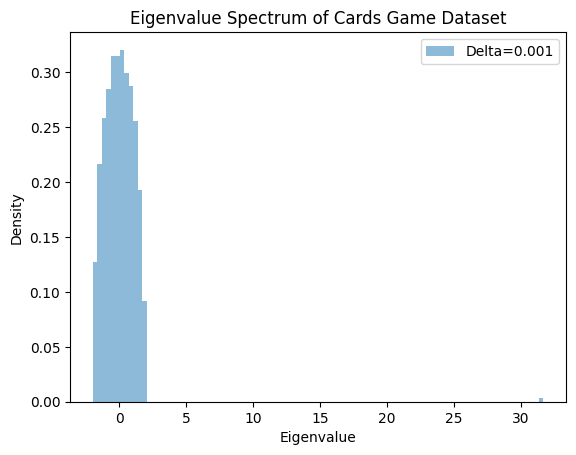

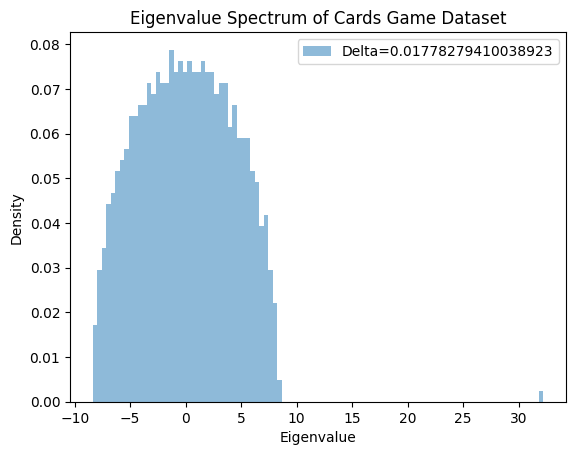

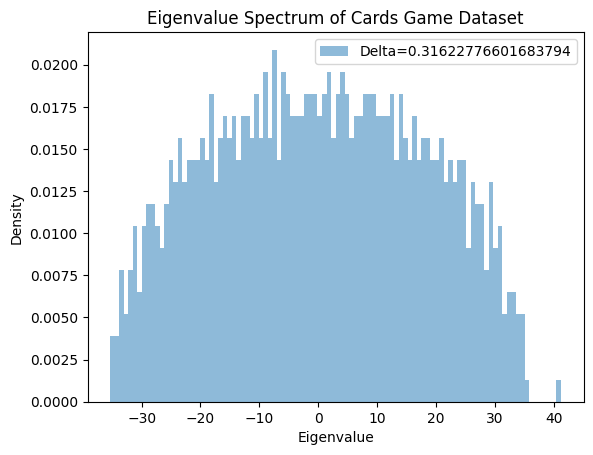

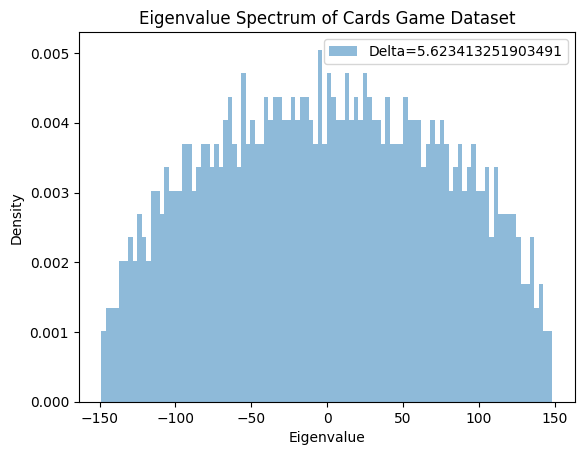

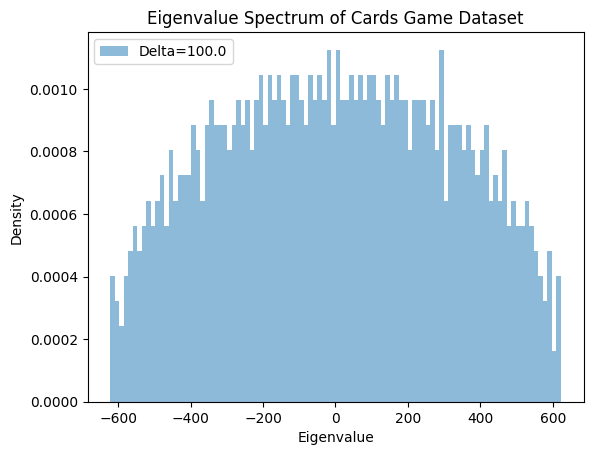

In [10]:
# Plot the spectrum for N = 1000, delta = {.001, .01, .1, 10, 100}

N = 1000
Deltas = np.logspace(-3, 2, 5)  # 0.001, 0.01, 0.1, 1, 10, 100 → ici je mets jusqu'à 100

for Delta in Deltas:
    s, Y = card_game_dataset(N, Delta)
    eigenvalues = np.linalg.eigvalsh(Y)
    plt.figure()
    plt.hist(eigenvalues, bins=100, density=True, alpha=0.5, label=f'Delta={Delta}')
    plt.title('Eigenvalue Spectrum of Cards Game Dataset')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

3. We are going to infer the cards' values $s_i$ using the spectral estimator $\hat{s}_i = \text{sign}(e_i^{\max})$, with $e_i^{\max}$ the $i$-th component of eigenvector corresponding to the largest eigenvalue. Compute the alignment $$Q = {\rm abs}\left(\frac{1}{N} \sum_{i=1}^N s_i \hat{s}_i \right).$$
Notice the absolute value in order to take into account the symmetry $s \to -s$ in the problem. Compute $Q$ for different values of $\Delta$ between 0 and 3. Average over 5 realizations for each considered value of $\Delta$, and plot $Q$ vs $\Delta$.  You should get a hint that there is a phase transition at a certain value of $\Delta$ (which one?). How is the spectrum of Y related to the recovery of the two groups?

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/var/folders/ml/mckm5tb169sckcm9zfghvmm80000gn/T/ipykernel_42933/717606142.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$')


Text(0, 0.5, 'Q')

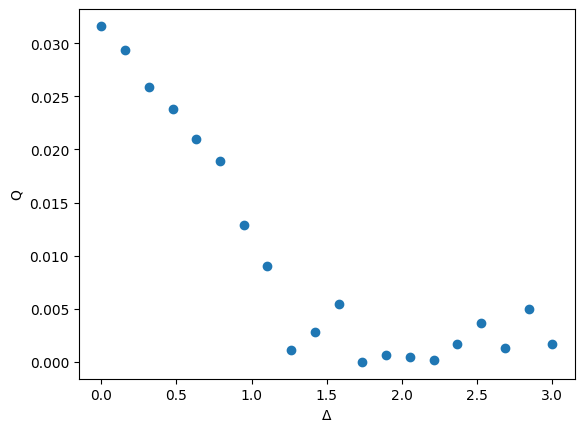

In [12]:
Deltas = np.linspace(0, 3, 20)

Q = []
exps = 5

for Delta in Deltas:
    for _ in range(exps):
        s, Y = card_game_dataset(N, Delta)
        eigenvalues, eigenvectors = np.linalg.eigh(Y)
        leading_eigenvector = eigenvectors[:, -1]
        q = (1/N) * np.abs(np.dot(s, leading_eigenvector))

    Q.append(q.mean())

plt.plot(Deltas, Q, 'o')
plt.xlabel('$\Delta$')
plt.ylabel('Q')

# Exercise 2: Cards Game with Monte Carlo



### Recovering $s^*$

The objective is to reconstruct the initial signal $ s^*$ via Monte Carlo Sampling.

We consider a slightly different setting, where our ground truth signal is again $s^* =(s^*_1,\dots,s^*_N)$, $s^*_i=\pm 1$ with equal probability.
Then we build the matrix $Y_{ij}=\frac{s_i^*s_j^*}{\sqrt{N}}+\sqrt{\Delta}W_{ij}$, for $i\neq j$,  and  $Y_{ii}=0\;\, \forall\; i\in[N]$, where $W_{ij}\sim N(0,1)$ come from a gaussian distribution and are all independent over $i<j$. Moreover $W_{ij}=W_{ji}$ so that $Y$ is symmetric.
$\{Y_{ij}\}_{i\in [N],j\in[N]}$ are our data.

Note that the difference is in the $Y_{ii}$ set to zero!

You saw in the lectures that the estimator $\hat s(Y)$ that minimizes the expected (over the posterior) square loss

$$
\text{MSE}=\mathbb E_{s^*|Y}\left[\frac{1}{N}\sum_i \left(\hat s(Y)_i-s^*_i\right)^2\right]
$$

is the Bayes estimator (or minimum mean square error estimator (mmse)) given by the mean of the posterior

$$
\hat s_{mmse}(Y)_i=\mathbb E_{s|Y} \left[ s_i\right].
$$

### Connection to systems in statistical physics
 Now consider a system of $N$ binary spins $s_1,\dots,s_N$, whose joint probability distribution is given by the posterior
 $$
 P(s|Y)=\frac{1}{Z(Y)} e^{-H(s;Y)}, \qquad H(s;Y)=-\frac{1}{\Delta\sqrt{N}}\sum_{i<j}Y_{ij}s_is_j
 $$
 Then the Bayes estimator is nothing but the magnetizations of the spins $s_i$.
 Denoting the average with respect to $P(s|Y)$ with $\langle\cdot\rangle$ we   can write
 $$
m_i=\langle s_i \rangle=\hat s_{mmse}(Y)_i.
 $$


For the single configuration $s$ we define its overlap with the ground truth $s^*$ as $\text{ov}(s,s^*)=\frac{1}{N}\sum_i s_is^*_i$

 In order to compute the magnetizations we implement a Markov Chain Monte Carlo algorithm that samples from the posterior.

 First we define the model

In [13]:
# Generating the planted signal (or ground truth)
N = 128  # Number of spins
Delta = 0.5  # Noise variance

np.random.seed(1234)

s_star, Y = card_game_dataset(N, Delta)

s_star = s_star.squeeze() # to remove all dimensions of size 1 from the array

for i in range(N): # Set to zero the diagonal elements
    Y[i, i] = 0

## MCMC Implementation

We're given $Y$ and we want to sample from the posterior $P(s|Y)$.
MCMC methods are based on designing a Markov chain whose stationary distribution is the distribution we want to sample from.
A Markov chain is a stochastic process consisting in a sequence of random variables $\{s^{(t)}\}_{t\in\mathbb N}$.
We will initialize the Markov chain on a random state and then update its state $s^{(t)}$.
There are many different Markov chains that have the same stationary probability. 
Here we will first implement the Metropolis rule for updating the state $s^{(t)}$.

### Metropolis

Let $s^{(t)}$ be the current state fo the Markov chain.
We draw an index $i\sim Unif([N])$ uniformly at random and propose to flip the spin $s_i$.
Let $s'=(s^{(t)}_1,\dots,s^{(t)}_{i-1},-s^{(t)}_i,s^{(t)}_{i+1},\dots,s^{(t)}_N)$ be the new proposed state.
We then compute the acceptance probability $P_{acc}(s^{(t)},s')=\min\{1, P(s'|Y)/P(s^{(t)}|Y)\}$.
We accept the proposal ($s^{(t+1)}=s'$) with probability $P_{acc}(s^{(t)},s')$. In practice, we draw a random variable $u$ uniformly distributed in $[0,1]$ and if $u<P_{acc}(s^{(t)},s')$, we set $s^{(t+1)}=s'$, otherwise we set $s^{(t+1)}=s^{(t)}$.


### Special case of Boltzmann measures
When we want to sample from a probability of the form $P(s) \propto e^{-H(s)}$, the acceptance probability can be written as $P_{acc}(s^{(t)},s')=\min\{1, \exp(H(s^{(t)})-H(s'))\}$.
In the particular case of the planted spin glass we have 
$$
    H(s')-H(s^{(t)})=\frac{2 s_i^{(t)}}{\Delta\sqrt{N}}\sum_k Y_{ik} s^{(t)}_k 
$$
Notice that the Hamiltonian is invariant under the transformation $s\to-s$, so when running the MCMC we might end up correlating either with $s$ or with $-s$. As a consequence $m$ might either be positive or negative.







In [27]:
def energy_difference(s, i, Y, Delta):
    '''
    Arguments:
    (s) current state, (i) flipped index, (Y) measurement matrix, (Delta) noise variance.
    Returns: 
    H(s')-H(s^t), where s' is obtained by flipping spin i in s^t.
    '''
    return 2 * s[i] / (Delta * np.sqrt(len(s))) * np.dot(Y[i, :], s)

In [28]:
# Uniformly random initial configuration to start the MCMC

np.random.seed(0)
s0 = 2*np.random.binomial(n=1, p=0.5, size=[N])-1

In [29]:
# Here are some quantities we want to keep track of during the dynamics

overlaps = [] # Keeping track of the overlap through time
energies = [-np.einsum('ij,i,j->', Y, s0, s0)/(2*np.sqrt(N)*Delta)] # Keep track of all the states visited by the Markov chain
state_history = [np.copy(s0)]

In [30]:
T = 10000
s = np.copy(s0) # Current state
np.random.seed(10)
for t in range(T):

    # Returns a uniformly distributed integer between 0 and N-1, extremes included
    i = np.random.randint(low=0, high=N)
    delta_H = energy_difference(s, i, Y, Delta)
    prob_accept = min(1, np.exp(-delta_H))
    if np.random.rand() < prob_accept:
        s[i] = -s[i]  # Flip the spin
        energies.append(energies[-1] + delta_H)
    else:
        energies.append(energies[-1])

    overlaps.append(np.mean(s*s_star))
    state_history.append(np.copy(s))

Once your Monte Carlo finally runs, make some plots by running the cells you see below (up to the section "Computing averages with MCMC").

You will plot overlaps, energies and configurations as a function of time. Are you seeing what you would expect?

If you have time you can change the value of $\Delta$ (for example to something larger than 1) and look for the differences.

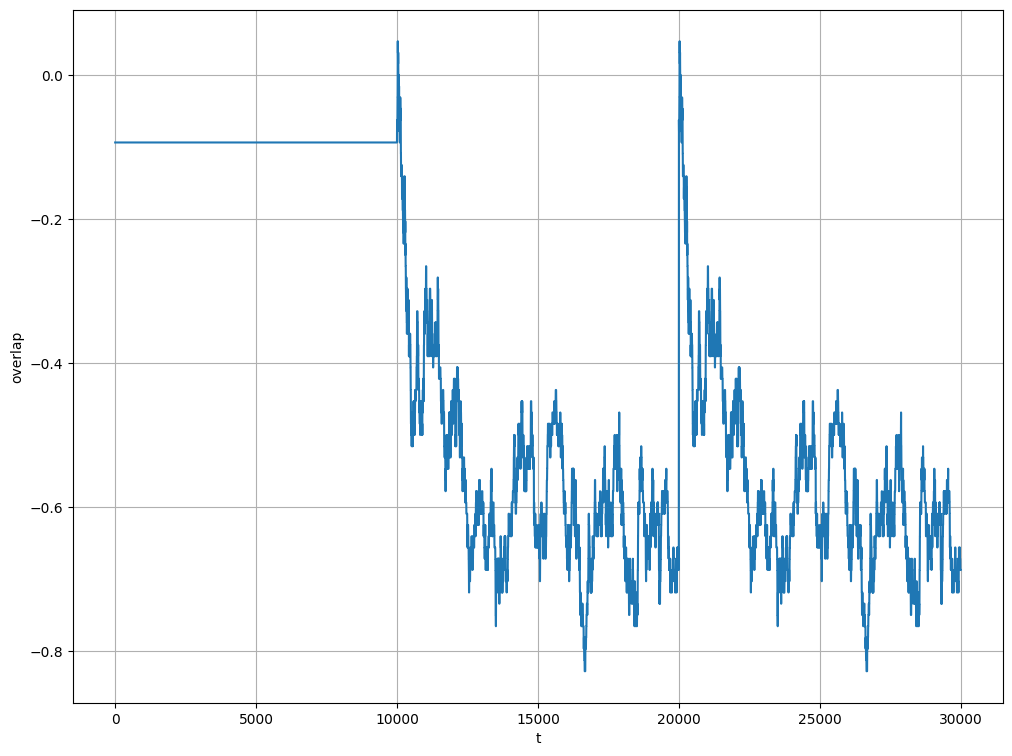

In [25]:
# Plot the overlap against the time

plt.figure(figsize=(12, 9))
plt.plot(overlaps)
plt.xlabel("t")
plt.ylabel("overlap")
plt.grid()

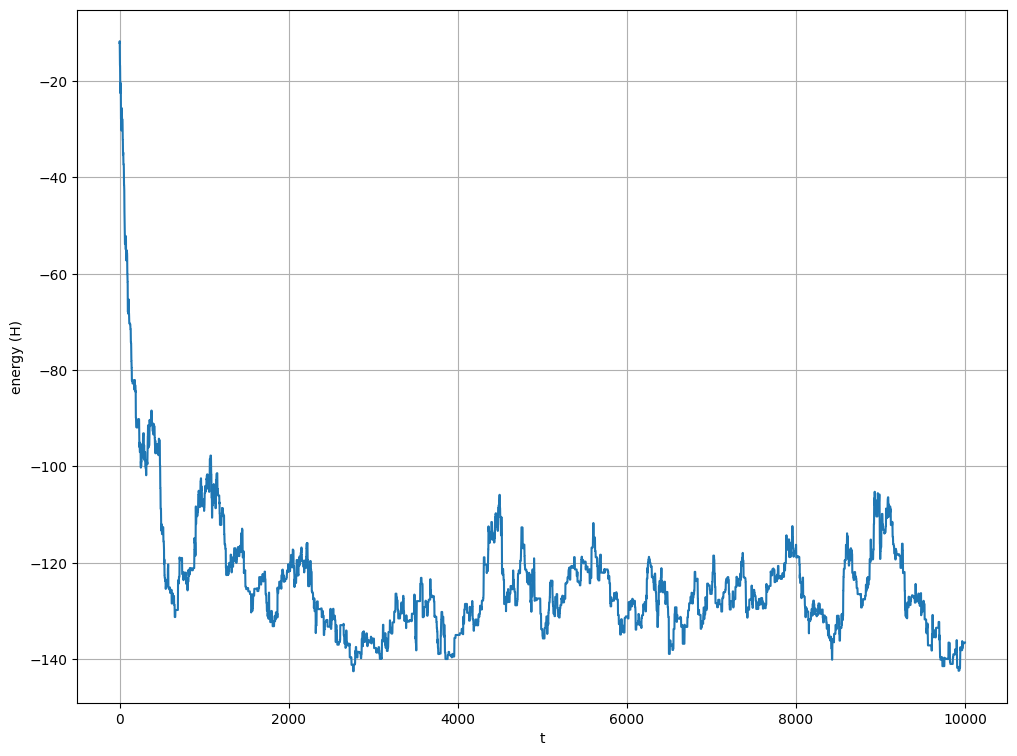

In [31]:
# Plot the energy against the time
plt.figure(figsize=(12, 9))
plt.plot(energies)
plt.xlabel("t")
plt.ylabel("energy (H)")
plt.grid()

## Computing averages from the MCMC

Suppose we want to compute the average over the posterior of an observable $A(s)$
To do this we use the fact that (under the ergodicity assumption) the time averages over the Markov chain converge to the ensemble averages. In formulas we have
$$
\lim_{T\to\infty} \frac{1}{T}\sum_{t=0}^T A(s^{(t)})=\langle A \rangle=\sum_{s} P(s|Y) A(s)
$$

In practice things are more involved.

As you saw, the Monte Carlo Markov chain needs some time to thermalize, before it starts sampling from the equilibrium measure. Configurations encountered in this initial *burn in* phase are not representative of the posterior, thus they should be discarded.
Let $T_{therm}$ be the time needed by the Markov chain to reach equilibrium, and $T$ the maximum time of the simulation.

Then we approximate
$$
\langle A \rangle \approx \frac{1}{T-T_{therm}}\sum_{t=T_{therm}}^T A(s^{(t)})
$$

### Obtaining the MMSE estimator
Remember that $\hat s_{mmse}(Y)_i=m_i=\langle s_i\rangle=\mathbb E_{s|Y} \left[ s_i\right]$ is the minimum mean square error estimator. We can approximate the average by the procedure explained above.


In [32]:
state_history = np.stack(state_history) # to stack the sequence of states together into a single NumPy array along a new axis

In [35]:
# Compute the mmse estimator from state_history using the procedure explained above.
# What do you think is a reasonable value for T_therm?

T_therm = 3000
# YOUR code here
mmse_estimator = np.mean(state_history[T_therm:, :], axis=0)

In [36]:
mmse_estimator[:20] # to check that the result makes sense

array([ 0.10555635, -0.804028  ,  0.97771747, -0.83459506,  0.41779746,
        1.        ,  0.83459506, -0.93572347, -0.80088559,  0.21611198,
       -0.86916155, -0.71118412,  0.9245822 ,  1.        , -0.45979146,
        1.        ,  0.77660334,  0.60348522,  0.87058992,  1.        ])

In [38]:
# Compute the mean squared error between the estimated signal and the true signal, considering both possible signs of the true signal, and keep the smaller one

# YOUR code here
mse = min([np.mean((mmse_estimator-s_star)**2), np.mean((mmse_estimator+s_star)**2)])
print("mean square error =", mse)

mean square error = 0.3816126679293127


## Estimating $T_{therm}$
 How do we know when our Markov chain has thermalized? In general there is no good answer to this question, however several heuristics can be used.
 

*   Look at when some observables (e.g. the energy) are stationary, i.e. their value stops drifting and fluctuates around a constant level.
*   Initialize two independent Markov chains, one random $s^{(0)}$ independent of $s^*$, and the other at $s^*$. Run the two Markov chains in parallel: $T_{therm}$ is the time at which the observables from the two chains have roughly the same value. This approach has the drawback of requiring the knowledge of $s^*$, which we normally don't have. However in some cases we know the structure of the ordered state (e.g. Ising, where $s_i=1 \;\forall i$), so the method can be applied.

Let's try this second approach: we run a Monte Carlo Markov chain initialized from the planted configuration $s^*$ and compare the energy and overlap.


In [39]:
# First we save the overlaps and energies obtained with the random initialization

overlaps_rand_s0 = overlaps.copy()
energies_rand_s0 = energies.copy()

In [40]:
# Re-execute the MCMC code, this time initializing s0=s_star. Remember to re-initialize all the variables!

s0 = np.copy(s_star)

overlaps = [] # Keeping track of the overlap through time
energies = [-np.einsum('ij,i,j->', Y, s0, s0)/(2*np.sqrt(N)*Delta)]
state_history = [np.copy(s0)]

In [41]:
T = 10000
s = np.copy(s0)  # Current state

for t in range(T):

    # Returns a uniformly distributed integer between 0 and N-1, extremes included
    i = np.random.randint(low=0, high=N)
    delta_H = energy_difference(s, i, Y, Delta)
    
    prob_accept = min(1, np.exp(-delta_H))
    if np.random.rand() < prob_accept:
        s[i] = -s[i]  # Flip the spin
        energies.append(energies[-1] + delta_H)
    else:
        energies.append(energies[-1])
    overlaps.append(np.mean(s*s_star))
    state_history.append(np.copy(s))


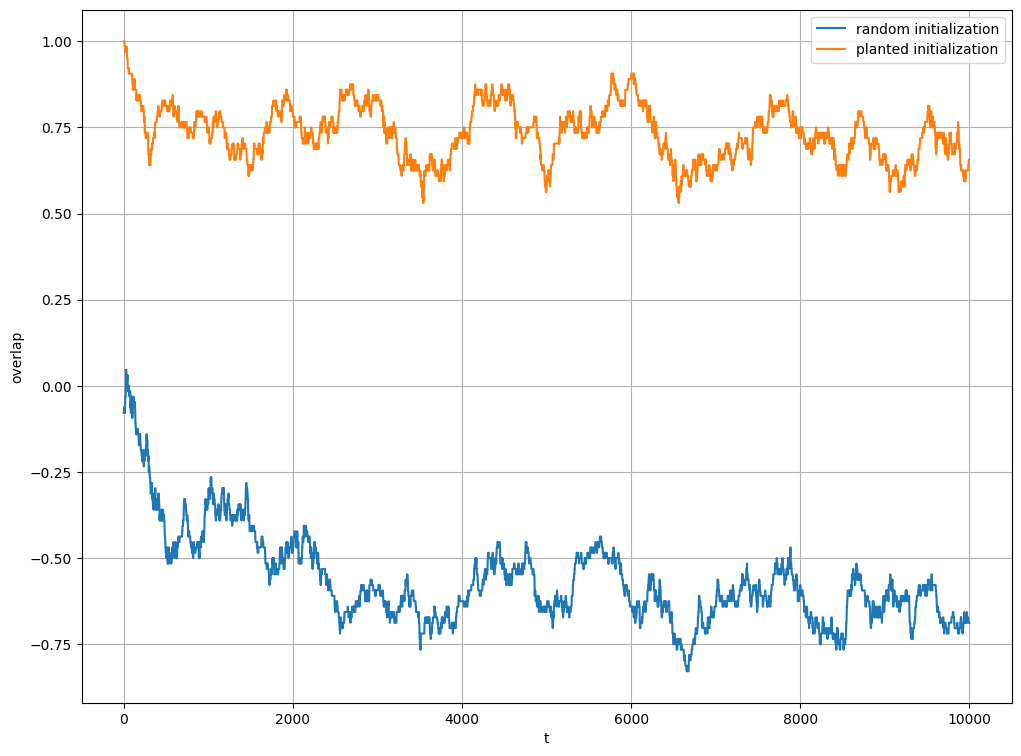

In [42]:
# Plot here the overlaps from the Markov chain with random initialization and the Markov with planted initialization, respectively

plt.figure(figsize=(12, 9))
plt.plot(overlaps_rand_s0, label='random initialization')
plt.plot(overlaps, label='planted initialization')
plt.grid()
plt.xlabel('t')
plt.ylabel('overlap')
plt.legend()